In [29]:
import json
import os
import time
from io import BytesIO
from urllib.parse import parse_qs, urlencode

import numpy as np
import pandas as pd
import requests
from dotenv import load_dotenv
from PIL import Image
from ratelimit import limits, sleep_and_retry
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Dict, Optional


## Curated Data Collection
To better curate the image set, I first created a dictionary of art movements and used the most popular
artists from that movement or style and whose works exemplify the genre defining characteristics. Then searched wiki art
by artist, collecting up to 50 works from each artist.


In [18]:
# Main dictionary mapping movements to artists
art_movements = {
    "naive_art": [
        "Joshua Johnson",
        "Henri Rousseau",
        "Edward Hicks",
        "John Bradley",
        "Alfred Wallis",
        "Grandma Moses",
        "Louis Vivin",
        "Seraphine Louis"
    ],
    "baroque": [
        "Paul Bril",
        "Agostino Carracci",
        "Annibale Carracci",
        "Hendrick Cornelisz Vroom",
        "Francesco Ribalta",
        "Caravaggio",
        "Jan Brueghel the Elder",
        "Peter Paul Rubens",
        "Georges Lallemand",
        "Guido Reni",
        "Francisco Herrera"
    ],
    "rococo": [
        "Francois Boucher",
        "Jean-Honore Fragonard",
        "Antoine Watteau",
        "Jean-Marc Nattier",
        "Maurice Quentin de La Tour",
        "Jean-Baptiste van Loo",
        "Charles-Andre van Loo",
        "Giovanni Battista Tiepolo",
        "Jean Baptiste Pater",
        "Francois Lemoyne",
        "Sebastiano Ricci",
        "Rosalba Carriera"
    ],
    "romanticism": [
        "Caspar David Friedrich",
        "J.M.W. Turner",
        "Eugene Delacroix",
        "Theodore Gericault",
        "John Constable",
        "Thomas Cole",
        "William Blake",
        "Henry Fuseli",
        "Francisco Goya",
        "Philipp Otto Runge",
        "Carl Carus",
        "Karl Schinkel"
    ],
    "art_deco": [
        "Tamara de Lempicka",
        "Erte",
        "Cassandre",
        "Paul Manship",
        "Rene Lalique",
        "Pierre Legrain",
        "Emile-Jacques Ruhlmann",
        "Jean Dupas",
        "Paul Colin", 
        "Romain de Tirtoff", 
        "Rene Vincent",
        "Robert Bonfils" 
    ],
    "american_realism": [
        "Edward Hopper",
        "Andrew Wyeth",
        "Charles Sheeler",
        "George Bellows",
        "Thomas Hart Benton", 
        "Reginald Marsh", 
        "Jack Levine", 
        "Edwin Dickinson", 
        "Ben Shahn", 
        "William Glackens", 
        "Ivan Albright",
        "Guy Pene du Bois" 
    ],
    "art_nouveau": [
        "Alphonse Mucha",
        "Gustav Klimt",
        "Henri de Toulouse-Lautrec",
        "Theophile Steinlen",
        "William Bradley", 
        "Eugene Grasset",
        "Theophile Roederer", 
        "Koloman Moser",  
        "Jan Toorop",
        "Jane Atche",
        "Elisabeth Sonrel",
        "Giovanni Mataloni" 
    ],
    "expressionism": [
        "Edvard Munch",
        "Ernst Ludwig Kirchner",
        "Wassily Kandinsky",
        "Emil Nolde",
        "Franz Marc",
        "August Macke",
        "Gabriele Munter",
        "Marianne von Werefkin",
        "Otto Dix", 
        "Karl Schmidt-Rottluff",
        "Erich Heckel",
        "Max Pechstein"
    ],
    "post_impressionism": [
        "Vincent van Gogh",
        "Paul Gauguin",
        "Paul Cezanne",
        "Georges Seurat",
        "Henri de Toulouse-Lautrec",
        "Emile Bernard",
        "Paul Signac",
        "Henri Rousseau",
        "Maurice Denis",
        "Edouard Vuillard",
        "Pierre Bonnard",
        "Felix Vallotton"
    ],
    "high_renaissance": [
        "Leonardo da Vinci",
        "Michelangelo",
        "Raphael",
        "Titian",
        "Andrea del Sarto",
        "Fra Bartolomeo",
        "Sebastiano del Piombo",
        "Giovanni Bellini",
        "Giorgione",
        "Lorenzo Lotto",
        "Pietro Perugino",
        "Benvenuto Tisi"
    ],
    "cubism": [
        "Pablo Picasso",
        "Georges Braque",
        "Juan Gris",
        "Fernand Leger",
        "Albert Gleizes",
        "Jean Metzinger",
        "Robert Delaunay",
        "Henri Le Fauconnier",
        "Andre Lhote",
        "Jacques Villon",
        "Louis Marcoussis",
        "Marie Laurencin"
    ],
    "abstract_expressionism": [
        "Jackson Pollock",
        "Willem de Kooning",
        "Mark Rothko",
        "Franz Kline",
        "Wassily Kandinsky",
        "Clyfford Still",
        "Robert Motherwell",
        "Helen Frankenthaler",
        "Lee Krasner",
        "Joan Mitchell",
        "Philip Guston",
        "Barnett Newman"
    ],
    "art_informel": [
        "Jean Dubuffet",
        "Jean Fautrier",
        "Georges Mathieu",
        "Antoni Tapies",
        "Alberto Burri",
        "Alfred Otto Wolfgang Schulze",
        "Hans Hartung",
        "Pierre Soulages",
        "Karel Appel",
        "Asger Jorn",
        "Emilio Vedova",
        "Jean-Paul Riopelle"
    ],
    "mannerism": [
        "Jacopo Pontormo",
        "Agnolo Bronzino",
        "Parmigianino",
        "Rosso Fiorentino",
        "Giorgio Vasari",
        "Federico Zuccari",
        "Girolamo Francesco Maria Mazzola",
        "Bartholomeus Spranger",
        "Giuseppe Arcimboldo",
        "Tintoretto",
        "El Greco",
        "Cecchino"
    ],
    "northern_renaissance": [
        "Jan van Eyck",
        "Albrecht Durer",
        "Hieronymus Bosch",
        "Pieter Bruegel the Elder",
        "Hans Holbein the Younger",
        "Robert Campin",
        "Rogier van der Weyden",
        "Hugo van der Goes",
        "Matthias Grunewald",
        "Hans Memling",
        "Gerard David",
        "Quentin Matsys"
    ],
    "surrealism": [
        "Salvador Dali",
        "Rene Magritte",
        "Max Ernst",
        "Joan Miro",
        "Andre Masson",
        "Yves Tanguy",
        "Paul Delvaux",
        "Leonora Carrington",
        "Dorothea Tanning",
        "Kay Sage",
        "Remedios Varo",
        "Giorgio de Chirico"
    ],
    "symbolism": [
        "Gustav Klimt",
        "Odilon Redon",
        "Gustave Moreau",
        "Jean Libert",
        "Fernand Khnopff",
        "Carlos Schwabe",
        "Mikalojus Ciurlionis",
        "Lucien Levy-Dhurmer",
        "Pierre Puvis de Chavannes",
        "Alexandre Seon",
        "William Degouve de Nuncques",
        "Arnold Bocklin"
    ],
    "early_renaissance": [
        "Masaccio",
        "Fra Angelico",
        "Sandro Botticelli",
        "Piero della Francesca",
        "Filippo Lippi",
        "Benozzo Gozzoli",
        "Paolo Uccello",
        "Domenico Ghirlandaio",
        "Gentile da Fabriano",
        "Andrea del Castagno",
        "Andrea Mantegna",
        "Carlo Crivelli"
    ],
    "modernism": [
        "Piet Mondrian",
        "Georgia O'Keeffe",
        "Charles Demuth",
        "Marsden Hartley",
        "Stuart Davis",
        "Charles Sheeler",
        "Joseph Stella",
        "Patrick Henry Bruce",
        "Arthur Dove",
        "John Marin",
        "Morton Schamberg",
        "Gerald Murphy"
    ],
    "contemporary": [
        "Peter Doig",
        "Anselm Kiefer",
        "Jenny Saville",
        "Marlene Dumas",
        "Neo Rauch", 
        "Julie Mehretu",
        "Luc Tuymans", 
        "Adrian Ghenie",
        "Njideka Akunyili Crosby",
        "Kerry James Marshall",
        "Michaël Borremans"
    ],
    "neo_romantic": [
        "Paul Nash",
        "Graham Sutherland"
    ],
    "ukiyo_e": [
        "Katsushika Hokusai",
        "Tsukioka Yoshitoshi", 
        "Kitagawa Utamaro",
        "Katsukawa Shunsho",
        "Toshuai Sharaku",
        "Utagawa Kuniyoshi",
        "Utagawa Kunisada",
        "Katsukawa Shunso",
        "Utagawa Toyokuni",
        "Isoda Koryusai",
        "Chobunsai Eishi",
        "Keisai Eisen"
    ],
    "impressionism": [
        "Claude Monet",
        "Pierre-Auguste Renoir",
        "Edgar Degas",
        "Camille Pissarro",
        "Alfred Sisley",
        "Berthe Morisot",
        "Mary Cassatt",
        "Gustave Caillebotte",
        "Armand Guillaumin",
        "Eva Gonzales",
        "Frederic Bazille",
        "Marie Bracquemond"
    ],
    "pop_art": [
        "Andy Warhol",
        "Roy Lichtenstein",
        "Claes Oldenburg",
        "Jim Dine", 
        "Richard Hamilton",
        "Peter Phillips", 
        "Keith Haring",
        "Robert Rauschenberg",
        "Peter Blake",
        "James Rosenquist",
        "Eduardo Paolozzi",
        "Yayoi Kusama"
    ],
    "fauvism": [
        "Henri Matisse",
        "Andre Derain",
        "Maurice de Vlaminck",
        "Georges Braque",
        "Raoul Dufy",
        "Albert Marquet",
        "Emile-Othon Friesz", 
        "Henri Manguin",
        "Georges Rouault", 
        "Louis Valtat",
        "Othon Friesz",
        "Kees van Dongen"
    ],
    "neoclassicism": [
        "Jacques-Louis David",
        "Jean Auguste Dominique Ingres",
        "Anton Raphael Mengs",
        "Angelica Kauffman",
        "Benjamin West",
        "Francois Gerard",
        "Anne-Louis Girodet",
        "Jean-Francois-Pierre Peyron",
        "Antonio Canova",
        "Marie-Guillemine Benoist",
        "Pierre-Paul Prud'hon",
        "Francois-Xavier Fabre"
    ],
    "minimalism": [
        "Frank Stella",
        "Agnes Martin",
        "Robert Ryman",
        "Ellsworth Kelly",
        "Ad Reinhardt",
        "Brice Marden",
        "Jo Baer",
        "Robert Mangold",
        "Carmen Herrera",
        "Anne Truitt",
        "Donald Judd", 
        "Sol LeWitt" 
    ]
}

### API Call
- First acquiring the metadata
- Then downloading the images
- Adhering to rate limiting

In [19]:
# Load our API access key
access_key = os.getenv('WIKIART_ACCESS_KEY')
secret_code = os.getenv('WIKIART_SECRET_KEY')

In [20]:
# API configuration
BASE_URL = "https://www.wikiart.org/en/api/2"
REQUESTS_PER_2_5_SECONDS = 10
REQUESTS_PER_HOUR = 400

session_key = None

@sleep_and_retry
@limits(calls=REQUESTS_PER_2_5_SECONDS, period=2.5)
def call_api():
    pass

@sleep_and_retry
@limits(calls=REQUESTS_PER_HOUR, period=3600)
def hourly_limit():
    pass

def get_session_key():
    login_url = f"{BASE_URL}/login"
    login_params = {
        "accessCode": access_key,
        "secretCode": secret_code
    }
    try:
        response = requests.get(login_url, params=login_params)
        response.raise_for_status()
        return response.json().get('SessionKey')
    except requests.exceptions.RequestException as e:
        print(f"Failed to retrieve session key: {e}")
        raise

def make_api_request(endpoint, params, max_retries=3, delay=5):
    global session_key
    if not session_key:
        session_key = get_session_key()

    for attempt in range(max_retries):
        try:
            call_api()
            hourly_limit()
            time.sleep(0.1)
            
            params['authSessionKey'] = session_key
            url = f"{BASE_URL}/{endpoint}"
            response = requests.get(url, params=params)
            response.raise_for_status()
            
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if 'limit exceeded' in str(e).lower():
                print("API rate limit exceeded. Waiting before retrying...")
                time.sleep(60)
            elif attempt < max_retries - 1:
                print(f"Retrying in {delay} seconds...")
                time.sleep(delay)
            else:
                print(f"Max retries reached. Unable to complete request to {endpoint}.")
                raise


In [22]:


BASE_URL = "https://www.wikiart.org/en/api/2"

def search_paintings_by_artist(artist_name: str, limit: int = 50) -> List[Dict]:
    """
    Search for paintings by artist name, with a limit on number of paintings returned.
    Uses the search endpoint instead of direct artist ID lookup.
    """
    all_paintings = []
    pagination_token = None
    has_more = True
    
    while has_more and len(all_paintings) < limit:
        try:
            # Base parameters
            params = {'term': artist_name}
            
            # Handle pagination token separately
            if pagination_token:
                params['paginationToken'] = pagination_token
            
            # Construct URL
            url = f"{BASE_URL}/PaintingSearch"
            param_strings = []
            for key, value in params.items():
                if key == 'paginationToken':
                    param_strings.append(f"{key}={value}")
                else:
                    param_strings.append(f"{key}={requests.utils.quote(str(value))}")
            
            url = f"{url}?{'&'.join(param_strings)}"
            
            # Make request
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            
            if not data or 'data' not in data:
                print(f"No data returned for artist {artist_name}")
                break
            
            # Filter results to only include works by this exact artist
            # (search might return similar names)
            filtered_paintings = [
                p for p in data['data'] 
                if p.get('artistName', '').lower() == artist_name.lower()
            ]
            
            # Add filtered paintings up to the limit
            remaining = limit - len(all_paintings)
            all_paintings.extend(filtered_paintings[:remaining])
            
            # Update pagination info
            has_more = data.get('hasMore', False) and len(all_paintings) < limit
            pagination_token = data.get('paginationToken')
            
            if has_more:
                time.sleep(0.5)  # Small delay between requests
                
        except Exception as e:
            print(f"Error retrieving paintings for artist {artist_name}: {str(e)}")
            break
            
    return all_paintings

def collect_paintings_by_movement(art_movements: Dict[str, List[str]], 
                                movement: str,
                                paintings_per_artist: int = 50) -> pd.DataFrame:
    """
    Collect paintings for all artists in a specific movement.
    
    Args:
        art_movements: Dictionary mapping movements to lists of artists
        movement: Name of the movement to collect paintings for
        paintings_per_artist: Maximum number of paintings to collect per artist
    
    Returns:
        DataFrame containing collected paintings with movement information
    """
    all_paintings = []
    artists = art_movements.get(movement, [])
    
    if not artists:
        print(f"No artists found for movement: {movement}")
        return pd.DataFrame()
    
    print(f"\nCollecting paintings for {movement} movement...")
    print(f"Number of artists to process: {len(artists)}")
    
    for artist in artists:
        try:
            paintings = search_paintings_by_artist(artist, paintings_per_artist)
            print(f"Found {len(paintings)} paintings for {artist}")
            
            # Add movement information to each painting
            for painting in paintings:
                painting['movement'] = movement
                
            all_paintings.extend(paintings)
            
        except Exception as e:
            print(f"Failed to process artist {artist}: {str(e)}")
            continue
    
    # Convert to DataFrame
    if not all_paintings:
        print("No paintings were collected")
        return pd.DataFrame()
        
    df = pd.DataFrame(all_paintings)
    
    print(f"\nCollection complete for {movement}!")
    print(f"Total paintings collected: {len(df)}")
    print(f"Total artists processed successfully: {df['artistName'].nunique()}")
    
    return df

def collect_all_movements(art_movements: Dict[str, List[str]], 
                         movements: Optional[List[str]] = None,
                         paintings_per_artist: int = 50) -> pd.DataFrame:
    """
    Collect paintings for multiple movements.
    
    Args:
        art_movements: Dictionary mapping movements to lists of artists
        movements: List of movements to collect (if None, collects all)
        paintings_per_artist: Maximum number of paintings to collect per artist
    
    Returns:
        DataFrame containing all collected paintings
    """
    all_paintings_dfs = []
    
    if movements is None:
        movements = list(art_movements.keys())
    
    for movement in movements:
        df = collect_paintings_by_movement(art_movements, movement, paintings_per_artist)
        if not df.empty:
            all_paintings_dfs.append(df)
    
    if not all_paintings_dfs:
        return pd.DataFrame()
    
    final_df = pd.concat(all_paintings_dfs, ignore_index=True)
    
    print("\nOverall Collection Summary:")
    print(f"Total paintings: {len(final_df)}")
    print(f"Total artists: {final_df['artistName'].nunique()}")
    print(f"Total movements: {final_df['movement'].nunique()}")
    
    return final_df

all_movements_df = collect_all_movements(art_movements, paintings_per_artist=40)


Number of artists to process: 8
Found 23 paintings for Joshua Johnson
Found 40 paintings for Henri Rousseau
Found 40 paintings for Edward Hicks
Found 18 paintings for John Bradley
Found 40 paintings for Alfred Wallis
Found 38 paintings for Grandma Moses
Found 30 paintings for Louis Vivin
Found 14 paintings for Seraphine Louis

Collection complete for naive_art!
Total paintings collected: 243
Total artists processed successfully: 8

Number of artists to process: 11
Found 28 paintings for Paul Bril
Found 40 paintings for Agostino Carracci
Found 40 paintings for Annibale Carracci
Found 16 paintings for Hendrick Cornelisz Vroom
Found 40 paintings for Francesco Ribalta
Found 40 paintings for Caravaggio
Found 40 paintings for Jan Brueghel the Elder
Found 40 paintings for Peter Paul Rubens
Found 8 paintings for Georges Lallemand
Found 40 paintings for Guido Reni
Found 20 paintings for Francisco Herrera

Collection complete for baroque!
Total paintings collected: 352
Total artists processed s

In [23]:
all_movements_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9200 entries, 0 to 9199
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                9200 non-null   object 
 1   title             9200 non-null   object 
 2   url               0 non-null      object 
 3   artistUrl         9200 non-null   object 
 4   artistName        9200 non-null   object 
 5   artistId          9200 non-null   object 
 6   completitionYear  7868 non-null   float64
 7   width             9200 non-null   int64  
 8   image             9200 non-null   object 
 9   height            9200 non-null   int64  
 10  movement          9200 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 790.8+ KB


In [24]:
all_movements_df.head()

,id,title,url,artistUrl,artistName,artistId,completitionYear,width,image,height,movement
0,57728a68edc2cb388010fa7e,Adelina Morton,None,joshua-johnson,Joshua Johnson,57726e02edc2cb3880b55dba,1810.0,496,https://uploads5.wikiart.org/images/joshua-joh...,600,naive_art
1,57728a68edc2cb388010fa90,BENJAMIN FRANKLIN YOE AND SON,None,joshua-johnson,Joshua Johnson,57726e02edc2cb3880b55dba,1810.0,483,https://uploads2.wikiart.org/images/joshua-joh...,600,naive_art
2,57728a69edc2cb388010faa0,Edward and Sarah Rutter,None,joshua-johnson,Joshua Johnson,57726e02edc2cb3880b55dba,1805.0,450,https://uploads4.wikiart.org/images/joshua-joh...,507,naive_art
3,57728a69edc2cb388010fab0,Family Group,None,joshua-johnson,Joshua Johnson,57726e02edc2cb3880b55dba,1800.0,750,https://uploads3.wikiart.org/images/joshua-joh...,483,naive_art
4,57728a69edc2cb388010fac0,Girl Wearing a Bonnet,None,joshua-johnson,Joshua Johnson,57726e02edc2cb3880b55dba,1810.0,504,https://uploads3.wikiart.org/images/joshua-joh...,600,naive_art


In [15]:
def download_image(image_url, save_path):
    try:
        # Send a GET request to the image URL
        response = requests.get(image_url)
        response.raise_for_status()  # Raise an exception for bad status codes

        # Open the image using PIL
        img = Image.open(BytesIO(response.content))

        # Save the image
        img.save(save_path)

    except requests.exceptions.RequestException as e:
        print(f"Error downloading the image: {e}")
    except IOError as e:
        print(f"Error saving the image: {e}")

In [16]:
# Create the save directory if it doesn't exist 
save_dir = "downloaded_images_wikiart"
os.makedirs(save_dir, exist_ok=True)

# Track successful and failed downloads
successful_downloads = 0
failed_downloads = []

# Get total number of images to download
total_images = len(all_movements_df)
print(f"Starting download of {total_images} images...")

# Process in batches of 20 with 1 minute delay between batches
batch_size = 20
for start_idx in tqdm(range(0, total_images, batch_size)):
    # Get the current batch
    batch = all_movements_df.iloc[start_idx:start_idx + batch_size]

    # Process each image in the batch
    for idx, row in batch.iterrows():
        # Create subdirectory for movement if it doesn't exist
        movement_dir = os.path.join(save_dir, row['movement'])
        os.makedirs(movement_dir, exist_ok=True)

        # Set up save path with movement subfolder
        filename = f"{row['id']}.jpg"
        save_path = os.path.join(movement_dir, filename)

        try:
            download_image(row['image'], save_path)
            successful_downloads += 1
            time.sleep(0.5)  # Small delay between individual downloads

        except Exception as e:
            failed_downloads.append({
                'id': row['id'],
                'movement': row['movement'],
                'url': row['image'],
                'error': str(e)
            })
            print(f"\nFailed to download {row['id']}: {e}")

    # After each batch, wait for a minute before continuing
    if start_idx + batch_size < total_images:  # Don't wait after the final batch
        print(f"\nCompleted batch. Waiting 60 seconds before next batch...")
        time.sleep(60)

# Print summary
print("\nDownload Summary:")
print(f"Total images attempted: {total_images}")
print(f"Successful downloads: {successful_downloads}")
print(f"Failed downloads: {len(failed_downloads)}")

if failed_downloads:
    print("\nFailed downloads details:")
    for fail in failed_downloads:
        print(f"ID: {fail['id']}")
        print(f"Movement: {fail['movement']}")
        print(f"URL: {fail['url']}")
        print(f"Error: {fail['error']}")
        print("-" * 50)

Starting download of 9200 images...


  0%|          | 0/460 [00:00<?, ?it/s]


Completed batch. Waiting 60 seconds before next batch...


  0%|          | 1/460 [01:18<10:02:17, 78.73s/it]


Completed batch. Waiting 60 seconds before next batch...


  0%|          | 2/460 [02:48<10:51:46, 85.39s/it]


Completed batch. Waiting 60 seconds before next batch...


  1%|          | 3/460 [04:20<11:11:26, 88.15s/it]


Completed batch. Waiting 60 seconds before next batch...


  1%|          | 4/460 [05:52<11:21:08, 89.62s/it]


Completed batch. Waiting 60 seconds before next batch...


  1%|          | 5/460 [07:23<11:24:49, 90.31s/it]


Completed batch. Waiting 60 seconds before next batch...


  1%|▏         | 6/460 [08:54<11:23:46, 90.37s/it]


Completed batch. Waiting 60 seconds before next batch...


  2%|▏         | 7/460 [10:24<11:21:48, 90.31s/it]


Completed batch. Waiting 60 seconds before next batch...


  2%|▏         | 8/460 [11:56<11:25:40, 91.02s/it]


Completed batch. Waiting 60 seconds before next batch...


  2%|▏         | 9/460 [13:24<11:17:23, 90.12s/it]


Completed batch. Waiting 60 seconds before next batch...


  2%|▏         | 10/460 [14:50<11:04:32, 88.61s/it]


Completed batch. Waiting 60 seconds before next batch...


  2%|▏         | 11/460 [16:13<10:49:56, 86.85s/it]


Completed batch. Waiting 60 seconds before next batch...


  3%|▎         | 12/460 [17:37<10:42:28, 86.05s/it]


Completed batch. Waiting 60 seconds before next batch...


  3%|▎         | 13/460 [19:00<10:34:34, 85.18s/it]


Completed batch. Waiting 60 seconds before next batch...


  3%|▎         | 14/460 [20:21<10:23:39, 83.90s/it]


Completed batch. Waiting 60 seconds before next batch...


  3%|▎         | 15/460 [21:44<10:20:04, 83.61s/it]


Completed batch. Waiting 60 seconds before next batch...


  3%|▎         | 16/460 [23:08<10:19:59, 83.78s/it]


Completed batch. Waiting 60 seconds before next batch...


  4%|▎         | 17/460 [24:32<10:19:20, 83.88s/it]


Completed batch. Waiting 60 seconds before next batch...


  4%|▍         | 18/460 [25:56<10:18:57, 84.02s/it]


Completed batch. Waiting 60 seconds before next batch...


  4%|▍         | 19/460 [27:20<10:15:49, 83.79s/it]


Completed batch. Waiting 60 seconds before next batch...


  4%|▍         | 20/460 [28:43<10:13:52, 83.71s/it]


Completed batch. Waiting 60 seconds before next batch...


  5%|▍         | 21/460 [30:04<10:06:54, 82.95s/it]


Completed batch. Waiting 60 seconds before next batch...


  5%|▍         | 22/460 [31:25<9:59:46, 82.16s/it] 


Completed batch. Waiting 60 seconds before next batch...


  5%|▌         | 23/460 [32:49<10:02:46, 82.76s/it]


Completed batch. Waiting 60 seconds before next batch...


  5%|▌         | 24/460 [34:14<10:07:22, 83.58s/it]


Completed batch. Waiting 60 seconds before next batch...


  5%|▌         | 25/460 [35:39<10:08:17, 83.90s/it]


Completed batch. Waiting 60 seconds before next batch...


  6%|▌         | 26/460 [37:05<10:10:36, 84.42s/it]

Error saving the image: cannot write mode P as JPEG

Completed batch. Waiting 60 seconds before next batch...


  6%|▌         | 27/460 [38:27<10:04:57, 83.83s/it]


Completed batch. Waiting 60 seconds before next batch...


  6%|▌         | 28/460 [39:53<10:06:58, 84.30s/it]


Completed batch. Waiting 60 seconds before next batch...


  6%|▋         | 29/460 [41:14<10:00:02, 83.53s/it]


Completed batch. Waiting 60 seconds before next batch...


  7%|▋         | 30/460 [42:39<10:02:17, 84.04s/it]


Completed batch. Waiting 60 seconds before next batch...


  7%|▋         | 31/460 [44:03<9:59:53, 83.90s/it] 


Completed batch. Waiting 60 seconds before next batch...


  7%|▋         | 32/460 [45:27<9:57:45, 83.80s/it]


Completed batch. Waiting 60 seconds before next batch...


  7%|▋         | 33/460 [46:49<9:52:23, 83.24s/it]


Completed batch. Waiting 60 seconds before next batch...


  7%|▋         | 34/460 [48:11<9:49:36, 83.04s/it]


Completed batch. Waiting 60 seconds before next batch...


  8%|▊         | 35/460 [49:37<9:53:10, 83.74s/it]


Completed batch. Waiting 60 seconds before next batch...


  8%|▊         | 36/460 [51:02<9:55:21, 84.25s/it]


Completed batch. Waiting 60 seconds before next batch...


  8%|▊         | 37/460 [52:28<9:57:21, 84.73s/it]


Completed batch. Waiting 60 seconds before next batch...


  8%|▊         | 38/460 [53:54<9:58:31, 85.10s/it]


Completed batch. Waiting 60 seconds before next batch...


  8%|▊         | 39/460 [55:19<9:57:48, 85.20s/it]

Error saving the image: cannot write mode RGBA as JPEG

Completed batch. Waiting 60 seconds before next batch...


  9%|▊         | 40/460 [56:44<9:54:49, 84.97s/it]


Completed batch. Waiting 60 seconds before next batch...


  9%|▉         | 41/460 [58:09<9:54:54, 85.19s/it]


Completed batch. Waiting 60 seconds before next batch...


  9%|▉         | 42/460 [59:34<9:51:50, 84.95s/it]


Completed batch. Waiting 60 seconds before next batch...


  9%|▉         | 43/460 [1:00:57<9:47:55, 84.59s/it]


Completed batch. Waiting 60 seconds before next batch...


 10%|▉         | 44/460 [1:02:22<9:46:48, 84.63s/it]

Error saving the image: cannot write mode RGBA as JPEG

Completed batch. Waiting 60 seconds before next batch...


 10%|▉         | 45/460 [1:03:46<9:43:36, 84.38s/it]


Completed batch. Waiting 60 seconds before next batch...


 10%|█         | 46/460 [1:05:09<9:38:20, 83.82s/it]


Completed batch. Waiting 60 seconds before next batch...


 10%|█         | 47/460 [1:06:32<9:36:17, 83.72s/it]


Completed batch. Waiting 60 seconds before next batch...


 10%|█         | 48/460 [1:07:58<9:39:54, 84.45s/it]


Completed batch. Waiting 60 seconds before next batch...


 11%|█         | 49/460 [1:09:24<9:41:27, 84.88s/it]


Completed batch. Waiting 60 seconds before next batch...


 11%|█         | 50/460 [1:10:48<9:37:12, 84.47s/it]


Completed batch. Waiting 60 seconds before next batch...


 11%|█         | 51/460 [1:12:08<9:28:15, 83.36s/it]


Completed batch. Waiting 60 seconds before next batch...


 11%|█▏        | 52/460 [1:13:29<9:22:03, 82.65s/it]


Completed batch. Waiting 60 seconds before next batch...


 12%|█▏        | 53/460 [1:14:58<9:32:19, 84.37s/it]


Completed batch. Waiting 60 seconds before next batch...


 12%|█▏        | 54/460 [1:16:30<9:46:19, 86.65s/it]


Completed batch. Waiting 60 seconds before next batch...


 12%|█▏        | 55/460 [1:17:56<9:44:16, 86.56s/it]


Completed batch. Waiting 60 seconds before next batch...


 12%|█▏        | 56/460 [1:19:25<9:47:09, 87.20s/it]


Completed batch. Waiting 60 seconds before next batch...


 12%|█▏        | 57/460 [1:20:54<9:49:37, 87.79s/it]


Completed batch. Waiting 60 seconds before next batch...


 13%|█▎        | 58/460 [1:22:21<9:46:07, 87.48s/it]


Completed batch. Waiting 60 seconds before next batch...


 13%|█▎        | 59/460 [1:23:50<9:47:32, 87.91s/it]


Completed batch. Waiting 60 seconds before next batch...


 13%|█▎        | 60/460 [1:25:18<9:48:00, 88.20s/it]


Completed batch. Waiting 60 seconds before next batch...


 13%|█▎        | 61/460 [1:26:49<9:51:50, 89.00s/it]


Completed batch. Waiting 60 seconds before next batch...


 13%|█▎        | 62/460 [1:28:16<9:46:28, 88.41s/it]


Completed batch. Waiting 60 seconds before next batch...


 14%|█▎        | 63/460 [1:29:42<9:38:39, 87.46s/it]


Completed batch. Waiting 60 seconds before next batch...


 14%|█▍        | 64/460 [1:30:58<9:14:35, 84.03s/it]


Completed batch. Waiting 60 seconds before next batch...


 14%|█▍        | 65/460 [1:32:14<8:57:09, 81.59s/it]


Completed batch. Waiting 60 seconds before next batch...


 14%|█▍        | 66/460 [1:33:38<9:01:47, 82.51s/it]


Completed batch. Waiting 60 seconds before next batch...


 15%|█▍        | 67/460 [1:35:04<9:06:08, 83.38s/it]


Completed batch. Waiting 60 seconds before next batch...


 15%|█▍        | 68/460 [1:36:29<9:08:15, 83.92s/it]


Completed batch. Waiting 60 seconds before next batch...


 15%|█▌        | 69/460 [1:37:54<9:10:11, 84.43s/it]


Completed batch. Waiting 60 seconds before next batch...


 15%|█▌        | 70/460 [1:39:20<9:10:11, 84.64s/it]


Completed batch. Waiting 60 seconds before next batch...


 15%|█▌        | 71/460 [1:40:42<9:04:18, 83.96s/it]


Completed batch. Waiting 60 seconds before next batch...


 16%|█▌        | 72/460 [1:42:06<9:03:33, 84.05s/it]


Completed batch. Waiting 60 seconds before next batch...


 16%|█▌        | 73/460 [1:43:28<8:58:28, 83.48s/it]


Completed batch. Waiting 60 seconds before next batch...


 16%|█▌        | 74/460 [1:44:51<8:55:26, 83.23s/it]


Completed batch. Waiting 60 seconds before next batch...


 16%|█▋        | 75/460 [1:46:13<8:51:08, 82.78s/it]


Completed batch. Waiting 60 seconds before next batch...


 17%|█▋        | 76/460 [1:47:37<8:52:30, 83.20s/it]


Completed batch. Waiting 60 seconds before next batch...


 17%|█▋        | 77/460 [1:48:58<8:46:55, 82.55s/it]


Completed batch. Waiting 60 seconds before next batch...


 17%|█▋        | 78/460 [1:50:22<8:47:53, 82.91s/it]


Completed batch. Waiting 60 seconds before next batch...


 17%|█▋        | 79/460 [1:51:49<8:55:05, 84.27s/it]


Completed batch. Waiting 60 seconds before next batch...


 17%|█▋        | 80/460 [1:53:14<8:55:08, 84.50s/it]


Completed batch. Waiting 60 seconds before next batch...


 18%|█▊        | 81/460 [1:54:33<8:43:52, 82.94s/it]


Completed batch. Waiting 60 seconds before next batch...


 18%|█▊        | 82/460 [1:55:56<8:41:44, 82.82s/it]


Completed batch. Waiting 60 seconds before next batch...


 18%|█▊        | 83/460 [1:57:21<8:44:02, 83.40s/it]

Error saving the image: cannot write mode LA as JPEG
Error saving the image: cannot write mode LA as JPEG

Completed batch. Waiting 60 seconds before next batch...


 18%|█▊        | 84/460 [1:58:45<8:43:57, 83.61s/it]


Completed batch. Waiting 60 seconds before next batch...


 18%|█▊        | 85/460 [2:00:11<8:46:34, 84.25s/it]


Completed batch. Waiting 60 seconds before next batch...


 19%|█▊        | 86/460 [2:01:34<8:43:44, 84.02s/it]


Completed batch. Waiting 60 seconds before next batch...


 19%|█▉        | 87/460 [2:03:00<8:46:23, 84.67s/it]


Completed batch. Waiting 60 seconds before next batch...


 19%|█▉        | 88/460 [2:04:23<8:41:36, 84.13s/it]


Completed batch. Waiting 60 seconds before next batch...


 19%|█▉        | 89/460 [2:05:48<8:40:58, 84.25s/it]


Completed batch. Waiting 60 seconds before next batch...


 20%|█▉        | 90/460 [2:07:12<8:39:24, 84.23s/it]


Completed batch. Waiting 60 seconds before next batch...


 20%|█▉        | 91/460 [2:08:37<8:39:30, 84.47s/it]


Completed batch. Waiting 60 seconds before next batch...


 20%|██        | 92/460 [2:10:04<8:42:51, 85.25s/it]


Completed batch. Waiting 60 seconds before next batch...


 20%|██        | 93/460 [2:11:29<8:40:34, 85.11s/it]


Completed batch. Waiting 60 seconds before next batch...


 20%|██        | 94/460 [2:12:54<8:40:24, 85.31s/it]


Completed batch. Waiting 60 seconds before next batch...


 21%|██        | 95/460 [2:14:20<8:40:15, 85.52s/it]


Completed batch. Waiting 60 seconds before next batch...


 21%|██        | 96/460 [2:15:41<8:29:55, 84.05s/it]


Completed batch. Waiting 60 seconds before next batch...


 21%|██        | 97/460 [2:17:03<8:25:24, 83.54s/it]


Completed batch. Waiting 60 seconds before next batch...


 21%|██▏       | 98/460 [2:18:28<8:26:32, 83.96s/it]


Completed batch. Waiting 60 seconds before next batch...


 22%|██▏       | 99/460 [2:19:53<8:26:29, 84.18s/it]


Completed batch. Waiting 60 seconds before next batch...


 22%|██▏       | 100/460 [2:21:14<8:20:03, 83.34s/it]


Completed batch. Waiting 60 seconds before next batch...


 22%|██▏       | 101/460 [2:22:38<8:19:04, 83.41s/it]


Completed batch. Waiting 60 seconds before next batch...


 22%|██▏       | 102/460 [2:24:03<8:20:58, 83.96s/it]


Completed batch. Waiting 60 seconds before next batch...


 22%|██▏       | 103/460 [2:25:28<8:21:24, 84.27s/it]


Completed batch. Waiting 60 seconds before next batch...


 23%|██▎       | 104/460 [2:26:52<8:19:51, 84.25s/it]


Completed batch. Waiting 60 seconds before next batch...


 23%|██▎       | 105/460 [2:28:16<8:17:20, 84.06s/it]


Completed batch. Waiting 60 seconds before next batch...


 23%|██▎       | 106/460 [2:29:41<8:16:54, 84.22s/it]


Completed batch. Waiting 60 seconds before next batch...


 23%|██▎       | 107/460 [2:31:06<8:17:54, 84.63s/it]


Completed batch. Waiting 60 seconds before next batch...


 23%|██▎       | 108/460 [2:32:27<8:09:15, 83.40s/it]


Completed batch. Waiting 60 seconds before next batch...


 24%|██▎       | 109/460 [2:33:52<8:10:35, 83.86s/it]


Completed batch. Waiting 60 seconds before next batch...


 24%|██▍       | 110/460 [2:35:18<8:12:54, 84.50s/it]


Completed batch. Waiting 60 seconds before next batch...


 24%|██▍       | 111/460 [2:36:45<8:15:42, 85.22s/it]


Completed batch. Waiting 60 seconds before next batch...


 24%|██▍       | 112/460 [2:38:11<8:16:11, 85.55s/it]


Completed batch. Waiting 60 seconds before next batch...


 25%|██▍       | 113/460 [2:39:37<8:16:15, 85.81s/it]


Completed batch. Waiting 60 seconds before next batch...


 25%|██▍       | 114/460 [2:41:01<8:10:15, 85.02s/it]


Completed batch. Waiting 60 seconds before next batch...


 25%|██▌       | 115/460 [2:42:25<8:07:19, 84.75s/it]


Completed batch. Waiting 60 seconds before next batch...


 25%|██▌       | 116/460 [2:43:46<7:59:20, 83.61s/it]


Completed batch. Waiting 60 seconds before next batch...


 25%|██▌       | 117/460 [2:45:10<7:59:08, 83.81s/it]


Completed batch. Waiting 60 seconds before next batch...


 26%|██▌       | 118/460 [2:46:34<7:57:51, 83.84s/it]


Completed batch. Waiting 60 seconds before next batch...


 26%|██▌       | 119/460 [2:47:56<7:53:03, 83.24s/it]


Completed batch. Waiting 60 seconds before next batch...


 26%|██▌       | 120/460 [2:49:21<7:54:56, 83.81s/it]


Completed batch. Waiting 60 seconds before next batch...


 26%|██▋       | 121/460 [2:50:45<7:53:34, 83.82s/it]


Completed batch. Waiting 60 seconds before next batch...


 27%|██▋       | 122/460 [2:52:09<7:53:36, 84.07s/it]


Completed batch. Waiting 60 seconds before next batch...


 27%|██▋       | 123/460 [2:53:36<7:57:25, 85.00s/it]


Completed batch. Waiting 60 seconds before next batch...


 27%|██▋       | 124/460 [2:55:00<7:54:15, 84.69s/it]


Completed batch. Waiting 60 seconds before next batch...


 27%|██▋       | 125/460 [2:56:25<7:52:13, 84.58s/it]


Completed batch. Waiting 60 seconds before next batch...


 27%|██▋       | 126/460 [2:57:40<7:36:03, 81.93s/it]


Completed batch. Waiting 60 seconds before next batch...


 28%|██▊       | 127/460 [2:58:57<7:25:57, 80.35s/it]


Completed batch. Waiting 60 seconds before next batch...


 28%|██▊       | 128/460 [3:00:20<7:29:25, 81.22s/it]


Completed batch. Waiting 60 seconds before next batch...


 28%|██▊       | 129/460 [3:01:45<7:34:03, 82.31s/it]


Completed batch. Waiting 60 seconds before next batch...


 28%|██▊       | 130/460 [3:03:08<7:33:57, 82.54s/it]


Completed batch. Waiting 60 seconds before next batch...


 28%|██▊       | 131/460 [3:04:24<7:21:26, 80.50s/it]


Completed batch. Waiting 60 seconds before next batch...


 29%|██▊       | 132/460 [3:05:44<7:19:30, 80.40s/it]


Completed batch. Waiting 60 seconds before next batch...


 29%|██▉       | 133/460 [3:07:10<7:27:27, 82.10s/it]


Completed batch. Waiting 60 seconds before next batch...


 29%|██▉       | 134/460 [3:08:36<7:31:55, 83.18s/it]


Completed batch. Waiting 60 seconds before next batch...


 29%|██▉       | 135/460 [3:10:02<7:34:42, 83.95s/it]


Completed batch. Waiting 60 seconds before next batch...


 30%|██▉       | 136/460 [3:11:28<7:36:54, 84.61s/it]


Completed batch. Waiting 60 seconds before next batch...


 30%|██▉       | 137/460 [3:12:53<7:36:04, 84.72s/it]


Completed batch. Waiting 60 seconds before next batch...


 30%|███       | 138/460 [3:14:19<7:37:08, 85.18s/it]


Completed batch. Waiting 60 seconds before next batch...


 30%|███       | 139/460 [3:15:44<7:35:02, 85.05s/it]


Completed batch. Waiting 60 seconds before next batch...


 30%|███       | 140/460 [3:17:09<7:33:39, 85.06s/it]


Completed batch. Waiting 60 seconds before next batch...


 31%|███       | 141/460 [3:18:34<7:32:44, 85.16s/it]


Completed batch. Waiting 60 seconds before next batch...


 31%|███       | 142/460 [3:19:57<7:26:52, 84.32s/it]

Error saving the image: cannot write mode RGBA as JPEG

Completed batch. Waiting 60 seconds before next batch...


 31%|███       | 143/460 [3:21:21<7:24:45, 84.18s/it]


Completed batch. Waiting 60 seconds before next batch...


 31%|███▏      | 144/460 [3:22:47<7:26:42, 84.82s/it]


Completed batch. Waiting 60 seconds before next batch...


 32%|███▏      | 145/460 [3:24:11<7:24:52, 84.74s/it]

Error saving the image: cannot write mode RGBA as JPEG

Completed batch. Waiting 60 seconds before next batch...


 32%|███▏      | 146/460 [3:25:36<7:23:34, 84.76s/it]


Completed batch. Waiting 60 seconds before next batch...


 32%|███▏      | 147/460 [3:27:00<7:20:57, 84.53s/it]


Completed batch. Waiting 60 seconds before next batch...


 32%|███▏      | 148/460 [3:28:25<7:19:47, 84.58s/it]


Completed batch. Waiting 60 seconds before next batch...


 32%|███▏      | 149/460 [3:29:49<7:18:05, 84.52s/it]


Completed batch. Waiting 60 seconds before next batch...


 33%|███▎      | 150/460 [3:31:15<7:17:56, 84.76s/it]

Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG

Completed batch. Waiting 60 seconds before next batch...


 33%|███▎      | 151/460 [3:32:41<7:18:22, 85.12s/it]


Completed batch. Waiting 60 seconds before next batch...


 33%|███▎      | 152/460 [3:34:06<7:17:59, 85.32s/it]

Error saving the image: cannot write mode RGBA as JPEG

Completed batch. Waiting 60 seconds before next batch...


 33%|███▎      | 153/460 [3:35:32<7:16:18, 85.27s/it]


Completed batch. Waiting 60 seconds before next batch...


 33%|███▎      | 154/460 [3:36:54<7:10:59, 84.51s/it]


Completed batch. Waiting 60 seconds before next batch...


 34%|███▎      | 155/460 [3:38:19<7:10:27, 84.68s/it]


Completed batch. Waiting 60 seconds before next batch...


 34%|███▍      | 156/460 [3:39:42<7:06:26, 84.17s/it]


Completed batch. Waiting 60 seconds before next batch...


 34%|███▍      | 157/460 [3:41:06<7:04:02, 83.97s/it]


Completed batch. Waiting 60 seconds before next batch...


 34%|███▍      | 158/460 [3:42:31<7:04:07, 84.26s/it]


Completed batch. Waiting 60 seconds before next batch...


 35%|███▍      | 159/460 [3:43:55<7:02:22, 84.19s/it]


Completed batch. Waiting 60 seconds before next batch...


 35%|███▍      | 160/460 [3:45:21<7:04:18, 84.86s/it]


Completed batch. Waiting 60 seconds before next batch...


 35%|███▌      | 161/460 [3:46:47<7:03:53, 85.06s/it]


Completed batch. Waiting 60 seconds before next batch...


 35%|███▌      | 162/460 [3:48:13<7:04:21, 85.44s/it]


Completed batch. Waiting 60 seconds before next batch...


 35%|███▌      | 163/460 [3:49:39<7:03:09, 85.49s/it]


Completed batch. Waiting 60 seconds before next batch...


 36%|███▌      | 164/460 [3:51:07<7:05:25, 86.24s/it]


Completed batch. Waiting 60 seconds before next batch...


 36%|███▌      | 165/460 [3:52:34<7:05:36, 86.57s/it]


Completed batch. Waiting 60 seconds before next batch...


 36%|███▌      | 166/460 [3:53:57<6:59:09, 85.54s/it]


Completed batch. Waiting 60 seconds before next batch...


 36%|███▋      | 167/460 [3:55:24<6:59:36, 85.93s/it]


Completed batch. Waiting 60 seconds before next batch...


 37%|███▋      | 168/460 [3:56:51<6:59:34, 86.21s/it]


Completed batch. Waiting 60 seconds before next batch...


 37%|███▋      | 169/460 [3:58:18<6:59:26, 86.48s/it]


Completed batch. Waiting 60 seconds before next batch...


 37%|███▋      | 170/460 [3:59:44<6:57:10, 86.31s/it]


Completed batch. Waiting 60 seconds before next batch...


 37%|███▋      | 171/460 [4:01:09<6:53:58, 85.95s/it]


Completed batch. Waiting 60 seconds before next batch...


 37%|███▋      | 172/460 [4:02:34<6:51:09, 85.66s/it]


Completed batch. Waiting 60 seconds before next batch...


 38%|███▊      | 173/460 [4:04:00<6:50:49, 85.89s/it]


Completed batch. Waiting 60 seconds before next batch...


 38%|███▊      | 174/460 [4:05:27<6:50:47, 86.18s/it]


Completed batch. Waiting 60 seconds before next batch...


 38%|███▊      | 175/460 [4:06:52<6:47:21, 85.76s/it]


Completed batch. Waiting 60 seconds before next batch...


 38%|███▊      | 176/460 [4:08:18<6:46:17, 85.84s/it]


Completed batch. Waiting 60 seconds before next batch...


 38%|███▊      | 177/460 [4:09:46<6:47:50, 86.47s/it]


Completed batch. Waiting 60 seconds before next batch...


 39%|███▊      | 178/460 [4:11:13<6:47:05, 86.62s/it]


Completed batch. Waiting 60 seconds before next batch...


 39%|███▉      | 179/460 [4:12:39<6:45:37, 86.61s/it]


Completed batch. Waiting 60 seconds before next batch...


 39%|███▉      | 180/460 [4:14:07<6:46:00, 87.00s/it]


Completed batch. Waiting 60 seconds before next batch...


 39%|███▉      | 181/460 [4:15:33<6:43:15, 86.72s/it]


Completed batch. Waiting 60 seconds before next batch...


 40%|███▉      | 182/460 [4:16:58<6:38:27, 86.00s/it]

Error saving the image: cannot write mode RGBA as JPEG

Completed batch. Waiting 60 seconds before next batch...


 40%|███▉      | 183/460 [4:18:23<6:36:18, 85.84s/it]


Completed batch. Waiting 60 seconds before next batch...


 40%|████      | 184/460 [4:19:50<6:35:59, 86.08s/it]

Error downloading the image: 522 Server Error:  for url: https://uploads2.wikiart.org/shimmering-substance(1).jpg!Large.jpg
Error downloading the image: 522 Server Error:  for url: https://uploads2.wikiart.org/stenographic-figure(1).jpg!Large.jpg
Error downloading the image: 522 Server Error:  for url: https://uploads0.wikiart.org/circumcision-january(1).jpg

Completed batch. Waiting 60 seconds before next batch...


 40%|████      | 185/460 [4:22:05<7:42:11, 100.84s/it]


Completed batch. Waiting 60 seconds before next batch...


 40%|████      | 186/460 [4:23:22<7:07:04, 93.52s/it] 

Error downloading the image: 522 Server Error:  for url: https://uploads7.wikiart.org/images/mark-rothko/aubade.jpg!Large.jpg
Error downloading the image: 522 Server Error:  for url: https://uploads3.wikiart.org/images/mark-rothko/cat-newyork.jpg!Large.jpg

Completed batch. Waiting 60 seconds before next batch...


 41%|████      | 187/460 [4:26:32<9:17:41, 122.57s/it]


Completed batch. Waiting 60 seconds before next batch...


 41%|████      | 188/460 [4:27:57<8:24:07, 111.20s/it]


Completed batch. Waiting 60 seconds before next batch...


 41%|████      | 189/460 [4:29:21<7:46:03, 103.19s/it]


Completed batch. Waiting 60 seconds before next batch...


 41%|████▏     | 190/460 [4:30:48<7:22:20, 98.30s/it] 


Completed batch. Waiting 60 seconds before next batch...


 42%|████▏     | 191/460 [4:32:13<7:02:46, 94.30s/it]


Completed batch. Waiting 60 seconds before next batch...


 42%|████▏     | 192/460 [4:33:38<6:49:04, 91.58s/it]


Completed batch. Waiting 60 seconds before next batch...


 42%|████▏     | 193/460 [4:35:04<6:39:50, 89.85s/it]


Completed batch. Waiting 60 seconds before next batch...


 42%|████▏     | 194/460 [4:36:29<6:31:20, 88.27s/it]


Completed batch. Waiting 60 seconds before next batch...


 42%|████▏     | 195/460 [4:37:54<6:26:29, 87.51s/it]


Completed batch. Waiting 60 seconds before next batch...


 43%|████▎     | 196/460 [4:39:19<6:20:38, 86.51s/it]


Completed batch. Waiting 60 seconds before next batch...


 43%|████▎     | 197/460 [4:40:43<6:16:33, 85.91s/it]


Completed batch. Waiting 60 seconds before next batch...


 43%|████▎     | 198/460 [4:42:09<6:15:46, 86.05s/it]


Completed batch. Waiting 60 seconds before next batch...


 43%|████▎     | 199/460 [4:43:36<6:14:23, 86.07s/it]


Completed batch. Waiting 60 seconds before next batch...


 43%|████▎     | 200/460 [4:44:59<6:08:59, 85.15s/it]


Completed batch. Waiting 60 seconds before next batch...


 44%|████▎     | 201/460 [4:46:25<6:08:47, 85.44s/it]


Completed batch. Waiting 60 seconds before next batch...


 44%|████▍     | 202/460 [4:47:50<6:06:35, 85.26s/it]


Completed batch. Waiting 60 seconds before next batch...


 44%|████▍     | 203/460 [4:49:15<6:05:52, 85.42s/it]


Completed batch. Waiting 60 seconds before next batch...


 44%|████▍     | 204/460 [4:50:41<6:04:41, 85.47s/it]


Completed batch. Waiting 60 seconds before next batch...


 45%|████▍     | 205/460 [4:52:03<5:59:21, 84.56s/it]


Completed batch. Waiting 60 seconds before next batch...


 45%|████▍     | 206/460 [4:53:29<5:59:09, 84.84s/it]


Completed batch. Waiting 60 seconds before next batch...


 45%|████▌     | 207/460 [4:54:56<6:00:28, 85.49s/it]


Completed batch. Waiting 60 seconds before next batch...


 45%|████▌     | 208/460 [4:56:24<6:02:20, 86.27s/it]


Completed batch. Waiting 60 seconds before next batch...


 45%|████▌     | 209/460 [4:57:51<6:01:56, 86.52s/it]


Completed batch. Waiting 60 seconds before next batch...


 46%|████▌     | 210/460 [4:59:19<6:02:34, 87.02s/it]


Completed batch. Waiting 60 seconds before next batch...


 46%|████▌     | 211/460 [5:00:46<6:01:18, 87.06s/it]


Completed batch. Waiting 60 seconds before next batch...


 46%|████▌     | 212/460 [5:02:12<5:58:38, 86.77s/it]


Completed batch. Waiting 60 seconds before next batch...


 46%|████▋     | 213/460 [5:03:37<5:53:49, 85.95s/it]


Completed batch. Waiting 60 seconds before next batch...


 47%|████▋     | 214/460 [5:05:02<5:51:49, 85.81s/it]


Completed batch. Waiting 60 seconds before next batch...


 47%|████▋     | 215/460 [5:06:29<5:51:36, 86.11s/it]


Completed batch. Waiting 60 seconds before next batch...


 47%|████▋     | 216/460 [5:07:55<5:50:06, 86.09s/it]


Completed batch. Waiting 60 seconds before next batch...


 47%|████▋     | 217/460 [5:09:22<5:49:24, 86.27s/it]


Completed batch. Waiting 60 seconds before next batch...


 47%|████▋     | 218/460 [5:10:46<5:46:20, 85.87s/it]


Completed batch. Waiting 60 seconds before next batch...


 48%|████▊     | 219/460 [5:12:14<5:46:59, 86.39s/it]


Completed batch. Waiting 60 seconds before next batch...


 48%|████▊     | 220/460 [5:13:42<5:47:48, 86.95s/it]


Completed batch. Waiting 60 seconds before next batch...


 48%|████▊     | 221/460 [5:15:10<5:46:53, 87.09s/it]


Completed batch. Waiting 60 seconds before next batch...


 48%|████▊     | 222/460 [5:16:36<5:44:30, 86.85s/it]


Completed batch. Waiting 60 seconds before next batch...


 48%|████▊     | 223/460 [5:18:03<5:42:49, 86.79s/it]


Completed batch. Waiting 60 seconds before next batch...


 49%|████▊     | 224/460 [5:19:27<5:38:47, 86.13s/it]


Completed batch. Waiting 60 seconds before next batch...


 49%|████▉     | 225/460 [5:20:53<5:36:36, 85.94s/it]


Completed batch. Waiting 60 seconds before next batch...


 49%|████▉     | 226/460 [5:22:19<5:35:04, 85.92s/it]


Completed batch. Waiting 60 seconds before next batch...


 49%|████▉     | 227/460 [5:23:44<5:33:28, 85.87s/it]


Completed batch. Waiting 60 seconds before next batch...


 50%|████▉     | 228/460 [5:25:09<5:30:03, 85.36s/it]


Completed batch. Waiting 60 seconds before next batch...


 50%|████▉     | 229/460 [5:26:35<5:29:22, 85.55s/it]


Completed batch. Waiting 60 seconds before next batch...


 50%|█████     | 230/460 [5:28:02<5:29:41, 86.01s/it]


Completed batch. Waiting 60 seconds before next batch...


 50%|█████     | 231/460 [5:29:27<5:27:53, 85.91s/it]


Completed batch. Waiting 60 seconds before next batch...


 50%|█████     | 232/460 [5:30:54<5:27:29, 86.18s/it]


Completed batch. Waiting 60 seconds before next batch...


 51%|█████     | 233/460 [5:32:18<5:23:54, 85.61s/it]


Completed batch. Waiting 60 seconds before next batch...


 51%|█████     | 234/460 [5:33:43<5:21:45, 85.42s/it]


Completed batch. Waiting 60 seconds before next batch...


 51%|█████     | 235/460 [5:35:09<5:20:01, 85.34s/it]


Completed batch. Waiting 60 seconds before next batch...


 51%|█████▏    | 236/460 [5:36:31<5:15:49, 84.60s/it]


Completed batch. Waiting 60 seconds before next batch...


 52%|█████▏    | 237/460 [5:37:56<5:14:33, 84.64s/it]


Completed batch. Waiting 60 seconds before next batch...


 52%|█████▏    | 238/460 [5:39:20<5:12:10, 84.37s/it]


Completed batch. Waiting 60 seconds before next batch...


 52%|█████▏    | 239/460 [5:40:45<5:11:36, 84.60s/it]


Completed batch. Waiting 60 seconds before next batch...


 52%|█████▏    | 240/460 [5:42:09<5:09:20, 84.36s/it]


Completed batch. Waiting 60 seconds before next batch...


 52%|█████▏    | 241/460 [5:43:35<5:10:23, 85.04s/it]

Error saving the image: cannot write mode RGBA as JPEG

Completed batch. Waiting 60 seconds before next batch...


 53%|█████▎    | 242/460 [5:45:02<5:10:24, 85.43s/it]


Completed batch. Waiting 60 seconds before next batch...


 53%|█████▎    | 243/460 [5:46:26<5:07:25, 85.00s/it]


Completed batch. Waiting 60 seconds before next batch...


 53%|█████▎    | 244/460 [5:47:50<5:05:35, 84.89s/it]


Completed batch. Waiting 60 seconds before next batch...


 53%|█████▎    | 245/460 [5:49:17<5:05:52, 85.36s/it]


Completed batch. Waiting 60 seconds before next batch...


 53%|█████▎    | 246/460 [5:50:41<5:03:23, 85.07s/it]


Completed batch. Waiting 60 seconds before next batch...


 54%|█████▎    | 247/460 [5:52:07<5:02:51, 85.31s/it]


Completed batch. Waiting 60 seconds before next batch...


 54%|█████▍    | 248/460 [5:53:34<5:03:15, 85.83s/it]


Completed batch. Waiting 60 seconds before next batch...


 54%|█████▍    | 249/460 [5:55:00<5:02:13, 85.94s/it]


Completed batch. Waiting 60 seconds before next batch...


 54%|█████▍    | 250/460 [5:56:26<4:59:59, 85.71s/it]


Completed batch. Waiting 60 seconds before next batch...


 55%|█████▍    | 251/460 [5:57:50<4:57:19, 85.35s/it]


Completed batch. Waiting 60 seconds before next batch...


 55%|█████▍    | 252/460 [5:59:15<4:55:20, 85.20s/it]


Completed batch. Waiting 60 seconds before next batch...


 55%|█████▌    | 253/460 [6:00:43<4:57:01, 86.09s/it]


Completed batch. Waiting 60 seconds before next batch...


 55%|█████▌    | 254/460 [6:02:08<4:54:34, 85.80s/it]


Completed batch. Waiting 60 seconds before next batch...


 55%|█████▌    | 255/460 [6:03:34<4:53:36, 85.94s/it]


Completed batch. Waiting 60 seconds before next batch...


 56%|█████▌    | 256/460 [6:04:59<4:50:59, 85.59s/it]


Completed batch. Waiting 60 seconds before next batch...


 56%|█████▌    | 257/460 [6:06:24<4:49:05, 85.45s/it]


Completed batch. Waiting 60 seconds before next batch...


 56%|█████▌    | 258/460 [6:07:50<4:47:50, 85.50s/it]


Completed batch. Waiting 60 seconds before next batch...


 56%|█████▋    | 259/460 [6:09:16<4:47:12, 85.73s/it]


Completed batch. Waiting 60 seconds before next batch...


 57%|█████▋    | 260/460 [6:10:42<4:46:02, 85.81s/it]


Completed batch. Waiting 60 seconds before next batch...


 57%|█████▋    | 261/460 [6:12:08<4:44:11, 85.69s/it]


Completed batch. Waiting 60 seconds before next batch...


 57%|█████▋    | 262/460 [6:13:34<4:43:20, 85.86s/it]


Completed batch. Waiting 60 seconds before next batch...


 57%|█████▋    | 263/460 [6:14:58<4:39:56, 85.26s/it]


Completed batch. Waiting 60 seconds before next batch...


 57%|█████▋    | 264/460 [6:16:25<4:39:58, 85.70s/it]


Completed batch. Waiting 60 seconds before next batch...


 58%|█████▊    | 265/460 [6:17:51<4:39:34, 86.02s/it]


Completed batch. Waiting 60 seconds before next batch...


 58%|█████▊    | 266/460 [6:19:18<4:38:33, 86.15s/it]


Completed batch. Waiting 60 seconds before next batch...


 58%|█████▊    | 267/460 [6:20:42<4:35:14, 85.57s/it]


Completed batch. Waiting 60 seconds before next batch...


 58%|█████▊    | 268/460 [6:22:10<4:36:06, 86.28s/it]


Completed batch. Waiting 60 seconds before next batch...


 58%|█████▊    | 269/460 [6:23:36<4:34:05, 86.10s/it]


Completed batch. Waiting 60 seconds before next batch...


 59%|█████▊    | 270/460 [6:25:01<4:31:56, 85.88s/it]


Completed batch. Waiting 60 seconds before next batch...


 59%|█████▉    | 271/460 [6:26:27<4:30:55, 86.01s/it]


Completed batch. Waiting 60 seconds before next batch...


 59%|█████▉    | 272/460 [6:27:52<4:28:09, 85.58s/it]


Completed batch. Waiting 60 seconds before next batch...


 59%|█████▉    | 273/460 [6:29:14<4:23:43, 84.62s/it]

Error saving the image: cannot write mode RGBA as JPEG

Completed batch. Waiting 60 seconds before next batch...


 60%|█████▉    | 274/460 [6:30:37<4:20:09, 83.92s/it]


Completed batch. Waiting 60 seconds before next batch...


 60%|█████▉    | 275/460 [6:31:57<4:15:50, 82.97s/it]


Completed batch. Waiting 60 seconds before next batch...


 60%|██████    | 276/460 [6:33:23<4:17:01, 83.81s/it]


Completed batch. Waiting 60 seconds before next batch...


 60%|██████    | 277/460 [6:34:47<4:15:59, 83.93s/it]


Completed batch. Waiting 60 seconds before next batch...


 60%|██████    | 278/460 [6:36:14<4:17:09, 84.78s/it]


Completed batch. Waiting 60 seconds before next batch...


 61%|██████    | 279/460 [6:37:39<4:15:52, 84.82s/it]


Completed batch. Waiting 60 seconds before next batch...


 61%|██████    | 280/460 [6:39:07<4:17:49, 85.94s/it]


Completed batch. Waiting 60 seconds before next batch...


 61%|██████    | 281/460 [6:40:34<4:16:31, 85.98s/it]


Completed batch. Waiting 60 seconds before next batch...


 61%|██████▏   | 282/460 [6:41:59<4:14:43, 85.86s/it]


Completed batch. Waiting 60 seconds before next batch...


 62%|██████▏   | 283/460 [6:43:26<4:14:15, 86.19s/it]


Completed batch. Waiting 60 seconds before next batch...


 62%|██████▏   | 284/460 [6:44:53<4:13:28, 86.41s/it]


Completed batch. Waiting 60 seconds before next batch...


 62%|██████▏   | 285/460 [6:46:21<4:13:01, 86.75s/it]


Completed batch. Waiting 60 seconds before next batch...


 62%|██████▏   | 286/460 [6:47:46<4:10:36, 86.41s/it]


Completed batch. Waiting 60 seconds before next batch...


 62%|██████▏   | 287/460 [6:49:10<4:07:12, 85.74s/it]


Completed batch. Waiting 60 seconds before next batch...


 63%|██████▎   | 288/460 [6:50:37<4:06:08, 85.87s/it]


Completed batch. Waiting 60 seconds before next batch...


 63%|██████▎   | 289/460 [6:52:01<4:03:30, 85.44s/it]


Completed batch. Waiting 60 seconds before next batch...


 63%|██████▎   | 290/460 [6:53:27<4:02:14, 85.50s/it]


Completed batch. Waiting 60 seconds before next batch...


 63%|██████▎   | 291/460 [6:54:53<4:01:44, 85.82s/it]


Completed batch. Waiting 60 seconds before next batch...


 63%|██████▎   | 292/460 [6:56:19<4:00:00, 85.72s/it]


Completed batch. Waiting 60 seconds before next batch...


 64%|██████▎   | 293/460 [6:57:43<3:57:43, 85.41s/it]


Completed batch. Waiting 60 seconds before next batch...


 64%|██████▍   | 294/460 [6:59:09<3:56:20, 85.42s/it]


Completed batch. Waiting 60 seconds before next batch...


 64%|██████▍   | 295/460 [7:00:31<3:52:13, 84.44s/it]


Completed batch. Waiting 60 seconds before next batch...


 64%|██████▍   | 296/460 [7:01:56<3:51:34, 84.72s/it]


Completed batch. Waiting 60 seconds before next batch...


 65%|██████▍   | 297/460 [7:03:20<3:49:00, 84.30s/it]

Error saving the image: cannot write mode RGBA as JPEG

Completed batch. Waiting 60 seconds before next batch...


 65%|██████▍   | 298/460 [7:04:43<3:46:43, 83.97s/it]


Completed batch. Waiting 60 seconds before next batch...


 65%|██████▌   | 299/460 [7:06:09<3:47:01, 84.60s/it]


Completed batch. Waiting 60 seconds before next batch...


 65%|██████▌   | 300/460 [7:07:33<3:44:55, 84.35s/it]


Completed batch. Waiting 60 seconds before next batch...


 65%|██████▌   | 301/460 [7:08:58<3:44:30, 84.72s/it]


Completed batch. Waiting 60 seconds before next batch...


 66%|██████▌   | 302/460 [7:10:20<3:40:54, 83.89s/it]


Completed batch. Waiting 60 seconds before next batch...


 66%|██████▌   | 303/460 [7:11:49<3:43:27, 85.40s/it]


Completed batch. Waiting 60 seconds before next batch...


 66%|██████▌   | 304/460 [7:13:15<3:42:40, 85.65s/it]


Completed batch. Waiting 60 seconds before next batch...


 66%|██████▋   | 305/460 [7:14:39<3:39:49, 85.09s/it]


Completed batch. Waiting 60 seconds before next batch...


 67%|██████▋   | 306/460 [7:16:04<3:38:14, 85.03s/it]


Completed batch. Waiting 60 seconds before next batch...


 67%|██████▋   | 307/460 [7:17:31<3:38:25, 85.66s/it]


Completed batch. Waiting 60 seconds before next batch...


 67%|██████▋   | 308/460 [7:18:57<3:37:04, 85.69s/it]


Completed batch. Waiting 60 seconds before next batch...


 67%|██████▋   | 309/460 [7:20:21<3:34:30, 85.24s/it]


Completed batch. Waiting 60 seconds before next batch...


 67%|██████▋   | 310/460 [7:21:46<3:32:28, 84.99s/it]


Completed batch. Waiting 60 seconds before next batch...


 68%|██████▊   | 311/460 [7:23:11<3:31:22, 85.12s/it]


Completed batch. Waiting 60 seconds before next batch...


 68%|██████▊   | 312/460 [7:24:35<3:28:59, 84.72s/it]


Completed batch. Waiting 60 seconds before next batch...


 68%|██████▊   | 313/460 [7:26:01<3:28:50, 85.24s/it]


Completed batch. Waiting 60 seconds before next batch...


 68%|██████▊   | 314/460 [7:27:26<3:27:15, 85.17s/it]


Completed batch. Waiting 60 seconds before next batch...


 68%|██████▊   | 315/460 [7:28:51<3:25:20, 84.97s/it]


Completed batch. Waiting 60 seconds before next batch...


 69%|██████▊   | 316/460 [7:30:16<3:23:49, 84.93s/it]


Completed batch. Waiting 60 seconds before next batch...


 69%|██████▉   | 317/460 [7:31:39<3:21:19, 84.47s/it]


Completed batch. Waiting 60 seconds before next batch...


 69%|██████▉   | 318/460 [7:33:04<3:20:30, 84.72s/it]


Completed batch. Waiting 60 seconds before next batch...


 69%|██████▉   | 319/460 [7:34:27<3:17:41, 84.12s/it]


Completed batch. Waiting 60 seconds before next batch...


 70%|██████▉   | 320/460 [7:35:52<3:16:55, 84.39s/it]


Completed batch. Waiting 60 seconds before next batch...


 70%|██████▉   | 321/460 [7:37:14<3:14:05, 83.78s/it]


Completed batch. Waiting 60 seconds before next batch...


 70%|███████   | 322/460 [7:38:38<3:12:31, 83.70s/it]


Completed batch. Waiting 60 seconds before next batch...


 70%|███████   | 323/460 [7:40:00<3:10:13, 83.31s/it]


Completed batch. Waiting 60 seconds before next batch...


 70%|███████   | 324/460 [7:41:24<3:08:59, 83.38s/it]


Completed batch. Waiting 60 seconds before next batch...


 71%|███████   | 325/460 [7:42:45<3:06:07, 82.73s/it]


Completed batch. Waiting 60 seconds before next batch...


 71%|███████   | 326/460 [7:44:05<3:03:11, 82.02s/it]


Completed batch. Waiting 60 seconds before next batch...


 71%|███████   | 327/460 [7:45:29<3:02:51, 82.49s/it]


Completed batch. Waiting 60 seconds before next batch...


 71%|███████▏  | 328/460 [7:46:52<3:01:37, 82.55s/it]


Completed batch. Waiting 60 seconds before next batch...


 72%|███████▏  | 329/460 [7:48:14<2:59:57, 82.42s/it]


Completed batch. Waiting 60 seconds before next batch...


 72%|███████▏  | 330/460 [7:49:35<2:58:03, 82.18s/it]


Completed batch. Waiting 60 seconds before next batch...


 72%|███████▏  | 331/460 [7:50:59<2:57:49, 82.71s/it]


Completed batch. Waiting 60 seconds before next batch...


 72%|███████▏  | 332/460 [7:52:22<2:56:18, 82.64s/it]


Completed batch. Waiting 60 seconds before next batch...


 72%|███████▏  | 333/460 [7:53:46<2:56:12, 83.25s/it]


Completed batch. Waiting 60 seconds before next batch...


 73%|███████▎  | 334/460 [7:55:12<2:56:30, 84.05s/it]


Completed batch. Waiting 60 seconds before next batch...


 73%|███████▎  | 335/460 [7:56:37<2:55:34, 84.27s/it]


Completed batch. Waiting 60 seconds before next batch...


 73%|███████▎  | 336/460 [7:58:01<2:53:56, 84.17s/it]

Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG

Completed batch. Waiting 60 seconds before next batch...


 73%|███████▎  | 337/460 [7:59:26<2:52:52, 84.33s/it]

Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG

Completed batch. Waiting 60 seconds before next batch...


 73%|███████▎  | 338/460 [8:00:52<2:52:42, 84.94s/it]

Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG

Completed batch. Waiting 60 seconds before next batch...


 74%|███████▎  | 339/460 [8:02:17<2:51:05, 84.84s/it]


Completed batch. Waiting 60 seconds before next batch...


 74%|███████▍  | 340/460 [8:03:41<2:49:19, 84.66s/it]


Completed batch. Waiting 60 seconds before next batch...


 74%|███████▍  | 341/460 [8:05:07<2:48:29, 84.96s/it]


Completed batch. Waiting 60 seconds before next batch...


 74%|███████▍  | 342/460 [8:06:31<2:46:28, 84.65s/it]

Error saving the image: cannot write mode RGBA as JPEG

Completed batch. Waiting 60 seconds before next batch...


 75%|███████▍  | 343/460 [8:07:57<2:46:05, 85.17s/it]


Completed batch. Waiting 60 seconds before next batch...


 75%|███████▍  | 344/460 [8:09:24<2:45:32, 85.63s/it]


Completed batch. Waiting 60 seconds before next batch...


 75%|███████▌  | 345/460 [8:10:50<2:44:39, 85.91s/it]


Completed batch. Waiting 60 seconds before next batch...


 75%|███████▌  | 346/460 [8:12:15<2:42:34, 85.57s/it]


Completed batch. Waiting 60 seconds before next batch...


 75%|███████▌  | 347/460 [8:13:39<2:40:05, 85.00s/it]


Completed batch. Waiting 60 seconds before next batch...


 76%|███████▌  | 348/460 [8:15:04<2:39:05, 85.22s/it]


Completed batch. Waiting 60 seconds before next batch...


 76%|███████▌  | 349/460 [8:16:31<2:38:13, 85.53s/it]


Completed batch. Waiting 60 seconds before next batch...


 76%|███████▌  | 350/460 [8:17:58<2:37:30, 85.92s/it]


Completed batch. Waiting 60 seconds before next batch...


 76%|███████▋  | 351/460 [8:19:24<2:36:34, 86.18s/it]


Completed batch. Waiting 60 seconds before next batch...


 77%|███████▋  | 352/460 [8:20:50<2:34:39, 85.92s/it]


Completed batch. Waiting 60 seconds before next batch...


 77%|███████▋  | 353/460 [8:22:13<2:32:02, 85.25s/it]


Completed batch. Waiting 60 seconds before next batch...


 77%|███████▋  | 354/460 [8:23:37<2:29:32, 84.64s/it]


Completed batch. Waiting 60 seconds before next batch...


 77%|███████▋  | 355/460 [8:25:03<2:29:19, 85.33s/it]


Completed batch. Waiting 60 seconds before next batch...


 77%|███████▋  | 356/460 [8:26:30<2:28:15, 85.54s/it]


Completed batch. Waiting 60 seconds before next batch...


 78%|███████▊  | 357/460 [8:27:56<2:27:22, 85.85s/it]


Completed batch. Waiting 60 seconds before next batch...


 78%|███████▊  | 358/460 [8:29:22<2:26:07, 85.95s/it]


Completed batch. Waiting 60 seconds before next batch...


 78%|███████▊  | 359/460 [8:30:48<2:24:42, 85.96s/it]


Completed batch. Waiting 60 seconds before next batch...


 78%|███████▊  | 360/460 [8:32:10<2:20:59, 84.60s/it]


Completed batch. Waiting 60 seconds before next batch...


 78%|███████▊  | 361/460 [8:33:36<2:20:19, 85.04s/it]


Completed batch. Waiting 60 seconds before next batch...


 79%|███████▊  | 362/460 [8:35:02<2:19:19, 85.30s/it]


Completed batch. Waiting 60 seconds before next batch...


 79%|███████▉  | 363/460 [8:36:29<2:18:45, 85.83s/it]


Completed batch. Waiting 60 seconds before next batch...


 79%|███████▉  | 364/460 [8:37:52<2:15:56, 84.96s/it]


Completed batch. Waiting 60 seconds before next batch...


 79%|███████▉  | 365/460 [8:39:16<2:14:27, 84.92s/it]


Completed batch. Waiting 60 seconds before next batch...


 80%|███████▉  | 366/460 [8:40:42<2:13:14, 85.05s/it]


Completed batch. Waiting 60 seconds before next batch...


 80%|███████▉  | 367/460 [8:42:09<2:12:36, 85.56s/it]


Completed batch. Waiting 60 seconds before next batch...


 80%|████████  | 368/460 [8:43:34<2:11:12, 85.57s/it]


Completed batch. Waiting 60 seconds before next batch...


 80%|████████  | 369/460 [8:45:01<2:10:29, 86.04s/it]


Completed batch. Waiting 60 seconds before next batch...


 80%|████████  | 370/460 [8:46:28<2:09:22, 86.24s/it]


Completed batch. Waiting 60 seconds before next batch...


 81%|████████  | 371/460 [8:47:56<2:08:33, 86.67s/it]


Completed batch. Waiting 60 seconds before next batch...


 81%|████████  | 372/460 [8:49:23<2:07:12, 86.73s/it]


Completed batch. Waiting 60 seconds before next batch...


 81%|████████  | 373/460 [8:50:49<2:05:39, 86.66s/it]


Completed batch. Waiting 60 seconds before next batch...


 81%|████████▏ | 374/460 [8:52:14<2:03:18, 86.03s/it]


Completed batch. Waiting 60 seconds before next batch...


 82%|████████▏ | 375/460 [8:53:40<2:02:08, 86.21s/it]


Completed batch. Waiting 60 seconds before next batch...


 82%|████████▏ | 376/460 [8:55:05<2:00:08, 85.82s/it]


Completed batch. Waiting 60 seconds before next batch...


 82%|████████▏ | 377/460 [8:56:28<1:57:32, 84.97s/it]


Completed batch. Waiting 60 seconds before next batch...


 82%|████████▏ | 378/460 [8:57:53<1:56:15, 85.07s/it]


Completed batch. Waiting 60 seconds before next batch...


 82%|████████▏ | 379/460 [8:59:20<1:55:23, 85.47s/it]


Completed batch. Waiting 60 seconds before next batch...


 83%|████████▎ | 380/460 [9:00:47<1:54:28, 85.85s/it]


Completed batch. Waiting 60 seconds before next batch...


 83%|████████▎ | 381/460 [9:02:14<1:53:33, 86.25s/it]


Completed batch. Waiting 60 seconds before next batch...


 83%|████████▎ | 382/460 [9:03:38<1:51:19, 85.63s/it]


Completed batch. Waiting 60 seconds before next batch...


 83%|████████▎ | 383/460 [9:05:02<1:49:21, 85.22s/it]


Completed batch. Waiting 60 seconds before next batch...


 83%|████████▎ | 384/460 [9:06:26<1:47:33, 84.91s/it]


Completed batch. Waiting 60 seconds before next batch...


 84%|████████▎ | 385/460 [9:07:52<1:46:22, 85.10s/it]


Completed batch. Waiting 60 seconds before next batch...


 84%|████████▍ | 386/460 [9:09:15<1:44:10, 84.46s/it]


Completed batch. Waiting 60 seconds before next batch...


 84%|████████▍ | 387/460 [9:10:37<1:41:58, 83.82s/it]


Completed batch. Waiting 60 seconds before next batch...


 84%|████████▍ | 388/460 [9:12:01<1:40:27, 83.71s/it]


Completed batch. Waiting 60 seconds before next batch...


 85%|████████▍ | 389/460 [9:13:24<1:38:54, 83.58s/it]


Completed batch. Waiting 60 seconds before next batch...


 85%|████████▍ | 390/460 [9:14:46<1:37:04, 83.20s/it]


Completed batch. Waiting 60 seconds before next batch...


 85%|████████▌ | 391/460 [9:16:08<1:35:10, 82.76s/it]


Completed batch. Waiting 60 seconds before next batch...


 85%|████████▌ | 392/460 [9:17:32<1:34:15, 83.17s/it]


Completed batch. Waiting 60 seconds before next batch...


 85%|████████▌ | 393/460 [9:18:57<1:33:20, 83.59s/it]


Completed batch. Waiting 60 seconds before next batch...


 86%|████████▌ | 394/460 [9:20:21<1:32:09, 83.78s/it]


Completed batch. Waiting 60 seconds before next batch...


 86%|████████▌ | 395/460 [9:21:46<1:31:01, 84.02s/it]


Completed batch. Waiting 60 seconds before next batch...


 86%|████████▌ | 396/460 [9:23:08<1:29:16, 83.69s/it]


Completed batch. Waiting 60 seconds before next batch...


 86%|████████▋ | 397/460 [9:24:31<1:27:22, 83.21s/it]


Completed batch. Waiting 60 seconds before next batch...


 87%|████████▋ | 398/460 [9:25:55<1:26:13, 83.44s/it]


Completed batch. Waiting 60 seconds before next batch...


 87%|████████▋ | 399/460 [9:27:19<1:25:06, 83.72s/it]


Completed batch. Waiting 60 seconds before next batch...


 87%|████████▋ | 400/460 [9:28:43<1:23:57, 83.96s/it]


Completed batch. Waiting 60 seconds before next batch...


 87%|████████▋ | 401/460 [9:30:09<1:23:04, 84.48s/it]


Completed batch. Waiting 60 seconds before next batch...


 87%|████████▋ | 402/460 [9:31:34<1:21:40, 84.49s/it]


Completed batch. Waiting 60 seconds before next batch...


 88%|████████▊ | 403/460 [9:32:59<1:20:28, 84.70s/it]


Completed batch. Waiting 60 seconds before next batch...


 88%|████████▊ | 404/460 [9:34:23<1:18:50, 84.47s/it]


Completed batch. Waiting 60 seconds before next batch...


 88%|████████▊ | 405/460 [9:35:46<1:17:00, 84.01s/it]


Completed batch. Waiting 60 seconds before next batch...


 88%|████████▊ | 406/460 [9:37:12<1:16:08, 84.60s/it]


Completed batch. Waiting 60 seconds before next batch...


 88%|████████▊ | 407/460 [9:38:36<1:14:39, 84.53s/it]


Completed batch. Waiting 60 seconds before next batch...


 89%|████████▊ | 408/460 [9:40:00<1:13:12, 84.48s/it]

Error saving the image: cannot write mode RGBA as JPEG

Completed batch. Waiting 60 seconds before next batch...


 89%|████████▉ | 409/460 [9:41:24<1:11:40, 84.32s/it]


Completed batch. Waiting 60 seconds before next batch...


 89%|████████▉ | 410/460 [9:42:51<1:10:57, 85.14s/it]


Completed batch. Waiting 60 seconds before next batch...


 89%|████████▉ | 411/460 [9:44:17<1:09:40, 85.31s/it]


Completed batch. Waiting 60 seconds before next batch...


 90%|████████▉ | 412/460 [9:45:43<1:08:26, 85.55s/it]


Completed batch. Waiting 60 seconds before next batch...


 90%|████████▉ | 413/460 [9:47:07<1:06:38, 85.07s/it]


Completed batch. Waiting 60 seconds before next batch...


 90%|█████████ | 414/460 [9:48:34<1:05:33, 85.51s/it]


Completed batch. Waiting 60 seconds before next batch...


 90%|█████████ | 415/460 [9:50:00<1:04:18, 85.74s/it]


Completed batch. Waiting 60 seconds before next batch...


 90%|█████████ | 416/460 [9:51:24<1:02:27, 85.17s/it]


Completed batch. Waiting 60 seconds before next batch...


 91%|█████████ | 417/460 [9:52:51<1:01:22, 85.63s/it]

Error saving the image: cannot write mode RGBA as JPEG

Completed batch. Waiting 60 seconds before next batch...


 91%|█████████ | 418/460 [9:54:17<1:00:12, 86.02s/it]


Completed batch. Waiting 60 seconds before next batch...


 91%|█████████ | 419/460 [9:55:43<58:42, 85.91s/it]  

Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG
Error saving the image: cannot write mode RGBA as JPEG

Completed batch. Waiting 60 seconds before next batch...


 91%|█████████▏| 420/460 [9:57:11<57:35, 86.38s/it]


Completed batch. Waiting 60 seconds before next batch...


 92%|█████████▏| 421/460 [9:58:38<56:15, 86.54s/it]


Completed batch. Waiting 60 seconds before next batch...


 92%|█████████▏| 422/460 [10:00:02<54:29, 86.03s/it]


Completed batch. Waiting 60 seconds before next batch...


 92%|█████████▏| 423/460 [10:01:27<52:50, 85.70s/it]


Completed batch. Waiting 60 seconds before next batch...


 92%|█████████▏| 424/460 [10:02:51<51:00, 85.02s/it]


Completed batch. Waiting 60 seconds before next batch...


 92%|█████████▏| 425/460 [10:04:15<49:28, 84.83s/it]


Completed batch. Waiting 60 seconds before next batch...


 93%|█████████▎| 426/460 [10:05:39<47:58, 84.67s/it]


Completed batch. Waiting 60 seconds before next batch...


 93%|█████████▎| 427/460 [10:07:04<46:30, 84.56s/it]


Completed batch. Waiting 60 seconds before next batch...


 93%|█████████▎| 428/460 [10:08:28<45:00, 84.40s/it]


Completed batch. Waiting 60 seconds before next batch...


 93%|█████████▎| 429/460 [10:09:53<43:43, 84.62s/it]

Error saving the image: cannot write mode RGBA as JPEG

Completed batch. Waiting 60 seconds before next batch...


 93%|█████████▎| 430/460 [10:11:19<42:28, 84.94s/it]


Completed batch. Waiting 60 seconds before next batch...


 94%|█████████▎| 431/460 [10:12:42<40:47, 84.40s/it]


Completed batch. Waiting 60 seconds before next batch...


 94%|█████████▍| 432/460 [10:14:05<39:12, 84.03s/it]


Completed batch. Waiting 60 seconds before next batch...


 94%|█████████▍| 433/460 [10:15:30<37:56, 84.32s/it]


Completed batch. Waiting 60 seconds before next batch...


 94%|█████████▍| 434/460 [10:16:56<36:47, 84.92s/it]


Completed batch. Waiting 60 seconds before next batch...


 95%|█████████▍| 435/460 [10:18:20<35:12, 84.50s/it]


Completed batch. Waiting 60 seconds before next batch...


 95%|█████████▍| 436/460 [10:19:44<33:48, 84.54s/it]


Completed batch. Waiting 60 seconds before next batch...


 95%|█████████▌| 437/460 [10:21:09<32:27, 84.66s/it]


Completed batch. Waiting 60 seconds before next batch...


 95%|█████████▌| 438/460 [10:22:32<30:52, 84.19s/it]


Completed batch. Waiting 60 seconds before next batch...


 95%|█████████▌| 439/460 [10:23:55<29:19, 83.80s/it]


Completed batch. Waiting 60 seconds before next batch...


 96%|█████████▌| 440/460 [10:25:18<27:50, 83.50s/it]


Completed batch. Waiting 60 seconds before next batch...


 96%|█████████▌| 441/460 [10:26:40<26:19, 83.12s/it]


Completed batch. Waiting 60 seconds before next batch...


 96%|█████████▌| 442/460 [10:28:04<24:57, 83.21s/it]


Completed batch. Waiting 60 seconds before next batch...


 96%|█████████▋| 443/460 [10:29:28<23:37, 83.40s/it]


Completed batch. Waiting 60 seconds before next batch...


 97%|█████████▋| 444/460 [10:30:53<22:23, 83.96s/it]


Completed batch. Waiting 60 seconds before next batch...


 97%|█████████▋| 445/460 [10:32:14<20:48, 83.21s/it]


Completed batch. Waiting 60 seconds before next batch...


 97%|█████████▋| 446/460 [10:33:35<19:14, 82.46s/it]


Completed batch. Waiting 60 seconds before next batch...


 97%|█████████▋| 447/460 [10:34:58<17:53, 82.59s/it]


Completed batch. Waiting 60 seconds before next batch...


 97%|█████████▋| 448/460 [10:36:19<16:27, 82.27s/it]


Completed batch. Waiting 60 seconds before next batch...


 98%|█████████▊| 449/460 [10:37:44<15:13, 83.07s/it]


Completed batch. Waiting 60 seconds before next batch...


 98%|█████████▊| 450/460 [10:39:07<13:49, 82.94s/it]


Completed batch. Waiting 60 seconds before next batch...


 98%|█████████▊| 451/460 [10:40:32<12:32, 83.59s/it]


Completed batch. Waiting 60 seconds before next batch...


 98%|█████████▊| 452/460 [10:41:56<11:08, 83.61s/it]


Completed batch. Waiting 60 seconds before next batch...


 98%|█████████▊| 453/460 [10:43:20<09:46, 83.77s/it]


Completed batch. Waiting 60 seconds before next batch...


 99%|█████████▊| 454/460 [10:44:41<08:18, 83.11s/it]


Completed batch. Waiting 60 seconds before next batch...


 99%|█████████▉| 455/460 [10:46:05<06:55, 83.09s/it]


Completed batch. Waiting 60 seconds before next batch...


 99%|█████████▉| 456/460 [10:47:27<05:31, 82.96s/it]


Completed batch. Waiting 60 seconds before next batch...


 99%|█████████▉| 457/460 [10:48:53<04:11, 83.70s/it]


Completed batch. Waiting 60 seconds before next batch...


100%|█████████▉| 458/460 [10:50:17<02:47, 83.98s/it]


Completed batch. Waiting 60 seconds before next batch...


100%|██████████| 460/460 [10:52:07<00:00, 85.06s/it]


Download Summary:
Total images attempted: 9200
Successful downloads: 9200
Failed downloads: 0


### Verify image downloads and remove entries that failed.

In [35]:

def verify_downloads(df, base_dir="downloaded_images_wikiart"):
    # Initialize counters and storage
    total_files = len(df)
    missing_files = 0
    missing_by_movement = {}
    verified_rows = []
    
    print(f"Starting verification of {total_files} files...")
    
    # Check each row in the DataFrame
    for _, row in tqdm(df.iterrows(), total=len(df)):
        movement_dir = os.path.join(base_dir, row['movement'])
        file_path = os.path.join(movement_dir, f"{row['id']}.jpg")
        
        # Check if file exists and has size greater than 0
        if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
            # Create a copy of the row data and add the file path
            row_data = row.to_dict()
            row_data['file_path'] = file_path
            verified_rows.append(row_data)
        else:
            missing_files += 1
            # Track missing files by movement
            missing_by_movement[row['movement']] = missing_by_movement.get(row['movement'], 0) + 1
    
    # Create new DataFrame with only verified files
    verified_df = pd.DataFrame(verified_rows)
    
    # Print summary
    print("\nVerification Summary:")
    print(f"Total files in DataFrame: {total_files}")
    print(f"Successfully downloaded: {total_files - missing_files}")
    print(f"Missing files: {missing_files}")
    
    if missing_files > 0:
        print("\nMissing files by movement:")
        for movement, count in sorted(missing_by_movement.items()):
            print(f"{movement}: {count} files missing")
    
    # Display sample of file paths to verify format
    print("\nSample of file paths (first 3):")
    if len(verified_df) > 0:
        print(verified_df['file_path'].head(3))
    
    return verified_df

# Run the verification
verified_df = verify_downloads(all_movements_df)

# Print movement distribution in verified dataset
print("\nVerified files distribution by movement:")
movement_counts = verified_df['movement'].value_counts()
for movement, count in movement_counts.items():
    print(f"{movement}: {count} files")

# Show DataFrame info including new file_path column
print("\nUpdated DataFrame Info:")
print(verified_df.info())


Starting verification of 9200 files...


100%|██████████| 9200/9200 [00:00<00:00, 10009.29it/s]


Verification Summary:
Total files in DataFrame: 9200
Successfully downloaded: 9114
Missing files: 86

Missing files by movement:
abstract_expressionism: 5 files missing
art_nouveau: 2 files missing
baroque: 1 files missing
contemporary: 21 files missing
cubism: 1 files missing
early_renaissance: 1 files missing
fauvism: 5 files missing
high_renaissance: 5 files missing
neoclassicism: 41 files missing
northern_renaissance: 1 files missing
rococo: 1 files missing
romanticism: 1 files missing
surrealism: 1 files missing

Sample of file paths (first 3):
0    downloaded_images_wikiart\naive_art\57728a68ed...
1    downloaded_images_wikiart\naive_art\57728a68ed...
2    downloaded_images_wikiart\naive_art\57728a69ed...
Name: file_path, dtype: object

Verified files distribution by movement:
early_renaissance: 466 files
abstract_expressionism: 459 files
post_impressionism: 458 files
minimalism: 453 files
impressionism: 444 files
expressionism: 440 files
surrealism: 434 files
high_renaissance: 

### Examine our classes

In [28]:
verified_df['movement'].value_counts()

movement
early_renaissance         466
abstract_expressionism    459
post_impressionism        458
minimalism                453
impressionism             444
expressionism             440
surrealism                434
high_renaissance          433
northern_renaissance      426
cubism                    413
pop_art                   392
fauvism                   361
baroque                   351
romanticism               336
mannerism                 327
art_informel              319
modernism                 301
rococo                    287
contemporary              280
american_realism          272
neoclassicism             272
art_nouveau               256
naive_art                 243
symbolism                 234
ukiyo_e                   230
art_deco                  147
neo_romantic               80
Name: count, dtype: int64

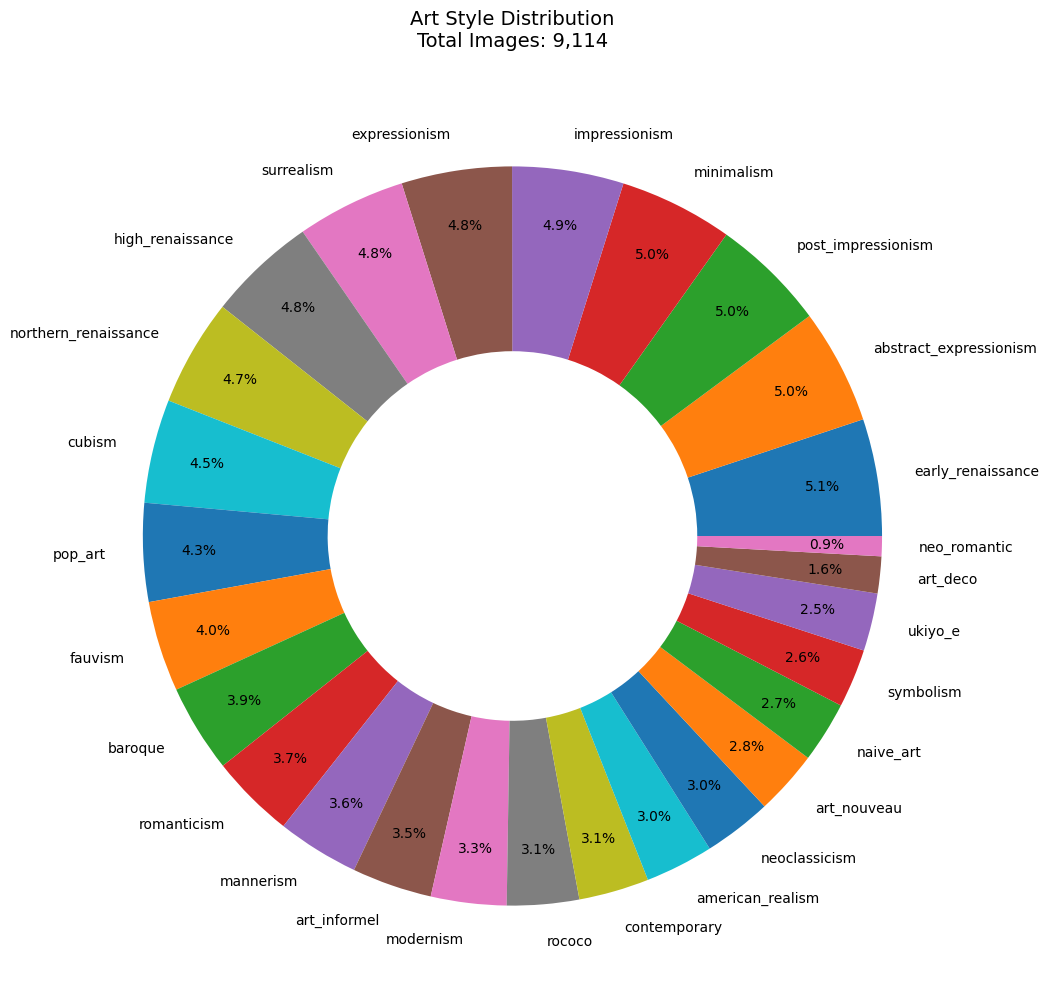

In [31]:
def plot_movement_pie(df):
    """
    Creates a pie chart of art style distribution using matplotlib
    """
    plt.figure(figsize=(12, 12))
    
    # Get style counts and total
    mvoement_counts = df['movement'].value_counts()
    total_images = len(df)
    
    # Create pie chart
    plt.pie(movement_counts.values, 
            labels=mvoement_counts.index,
            autopct='%1.1f%%',
            pctdistance=0.85,
            wedgeprops=dict(width=0.5))  # Creates donut effect
    
    plt.title(f"Art Style Distribution\nTotal Images: {total_images:,}", 
              pad=20, 
              size=14)
    
    return plt

#Usage:
plot_movement_pie(verified_df)
plt.show()

In [36]:
# Save the dataframe to be used for image processing
verified_df.to_csv('verified_artwork_data.csv', index=False)